<a href="https://colab.research.google.com/github/Shreya07099/Job_Post_detection_Project/blob/main/Copy_of_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: Setup

# 1. Mount your Google Drive to save the model permanently
from google.colab import drive
drive.mount('/content/drive')
print("✅ Google Drive mounted successfully!")

# 2. Install required Python libraries quietly (-q)
print("\n🚀 Installing necessary libraries...")
!pip install transformers[torch] pandas scikit-learn seaborn -q
print("✅ Libraries installed!")

Mounted at /content/drive
✅ Google Drive mounted successfully!

🚀 Installing necessary libraries...
✅ Libraries installed!


In [ ]:
# CELL 2: LOAD & COMBINE DATA (READING AS EXCEL FILES)

import pandas as pd

# 1. Define the exact file paths in your Google Drive
file_path1 = '/content/drive/MyDrive/Colab Notebooks/FP1.csv.xlsx'
file_path2 = '/content/drive/MyDrive/Colab Notebooks/FP2.csv.xlsx'

# 2. Load each file using pd.read_excel()
try:
    # THE FIX: Switched to pd.read_excel() to handle .xlsx files
    df1 = pd.read_excel(file_path1)
    df2 = pd.read_excel(file_path2)
    print("✅ Both Excel files loaded successfully from your specific Drive paths!")

    # 3. Combine them into one master DataFrame
    master_df = pd.concat([df1, df2], ignore_index=True)
    print(f"✅ DataFrames combined! The new dataset has {len(master_df)} total rows.")

    # 4. Rename 'salary_range' for consistency
    if 'salary_range' in master_df.columns:
        master_df.rename(columns={'salary_range': 'salaryRange'}, inplace=True)

    print("\n--- Master DataFrame Info ---")
    master_df.info()

except FileNotFoundError as e:
    print(f"❌ ERROR: File not found. Please double-check the file path and name in your Google Drive: {e.filename}")
except Exception as e:
    print(f"❌ An error occurred: {e}")

✅ Both Excel files loaded successfully from your specific Drive paths!
✅ DataFrames combined! The new dataset has 27887 total rows.

--- Master DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27887 entries, 0 to 27886
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   title                27880 non-null  object 
 1   description          27871 non-null  object 
 2   requirements         25146 non-null  object 
 3   company_profile      24572 non-null  object 
 4   location             27534 non-null  object 
 5   salaryRange          12868 non-null  object 
 6   employment_type      10000 non-null  object 
 7   industry             22977 non-null  object 
 8   benefits             20637 non-null  object 
 9   fraudulent           27880 non-null  float64
 10  JOB DESCRIPTION      27808 non-null  object 
 11  Unnamed: 11          0 non-null      float64
 12  Telecomuting         0 

In [ ]:
# CELL 3: FEATURE ENGINEERING (PERFECTED)

# 1. Combine all relevant text fields into one for easier processing
# This list is now updated to match the exact columns in your DataFrame
text_cols = [
    'title', 'description', 'requirements', 'company_profile',
    'benefits', 'industry', 'JOB DESCRIPTION'
]

# Filter to only include columns that actually exist to prevent errors
existing_text_cols = [col for col in text_cols if col in master_df.columns]
master_df['full_text'] = master_df[existing_text_cols].fillna('').agg(' '.join, axis=1)
print("✅ Combined text fields into 'full_text' column.")

# 2. Engineer new features for analysis
master_df['text_length'] = master_df['full_text'].str.len()
suspicious_keywords = ['urgent', 'confidential', 'no experience', 'money', 'click here', 'limited time']
master_df['has_suspicious_keyword'] = master_df['full_text'].str.contains('|'.join(suspicious_keywords), case=False).astype(int)
master_df['has_company_profile'] = master_df['company_profile'].notna().astype(int)
master_df['has_benefits'] = master_df['benefits'].notna().astype(int)
master_df['has_salary'] = master_df['salaryRange'].notna().astype(int)

print("✅ Feature engineering complete!")
display(master_df[['fraudulent', 'text_length', 'has_suspicious_keyword', 'has_company_profile']].head())

✅ Combined text fields into 'full_text' column.
✅ Feature engineering complete!


,fraudulent,text_length,has_suspicious_keyword,has_company_profile
0,1.0,394,0,1
1,1.0,465,0,1
2,1.0,429,0,1
3,1.0,446,0,1
4,1.0,492,0,1


In [ ]:
# NEW CELL: DATA CLEANING

print(f"Original shape of data: {master_df.shape}")

# 1. Drop useless and empty columns
# We identified these from the .info() output
cols_to_drop = ['Unnamed: 10', 'Unnamed: 11', 'Telecomuting'] # Note the spelling on the last one
master_df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
print(f"Dropped useless columns. New shape: {master_df.shape}")

# 2. Clean the 'fraudulent' target variable
# Remove the few rows where the 'fraudulent' label is missing
master_df.dropna(subset=['fraudulent'], inplace=True)
# Convert the column to integer type (0 or 1)
master_df['fraudulent'] = master_df['fraudulent'].astype(int)
print(f"Cleaned the target variable. Final shape: {master_df.shape}")

print("\n✅ Data cleaning complete!")
print("\n--- Cleaned DataFrame Info ---")
master_df.info()

Original shape of data: (27887, 23)
Dropped useless columns. New shape: (27887, 20)
Cleaned the target variable. Final shape: (27880, 20)

✅ Data cleaning complete!

--- Cleaned DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 27880 entries, 0 to 27886
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   title                   27880 non-null  object 
 1   description             27871 non-null  object 
 2   requirements            25146 non-null  object 
 3   company_profile         24572 non-null  object 
 4   location                27534 non-null  object 
 5   salaryRange             12868 non-null  object 
 6   employment_type         10000 non-null  object 
 7   industry                22977 non-null  object 
 8   benefits                20637 non-null  object 
 9   fraudulent              27880 non-null  int64  
 10  JOB DESCRIPTION         27808 non-null  object 
 11  depar

In [ ]:
# NEW CELL: SAVE THE FINAL CLEANED DATAFRAME

print("💾 Saving the final master_df to Google Drive...")

# Define the path where you want to save the file
save_path = '/content/drive/MyDrive/Colab Notebooks/master_dataset_cleaned.csv'

# Save the master_df DataFrame to a CSV file
# index=False prevents pandas from writing the row numbers into the file
master_df.to_csv(save_path, index=False)

print(f"✅ DataFrame saved successfully to:\n{save_path}")

💾 Saving the final master_df to Google Drive...
✅ DataFrame saved successfully to:
/content/drive/MyDrive/Colab Notebooks/master_dataset_cleaned.csv


--- LOGIC 1: BIVARIATE ANALYSIS ---


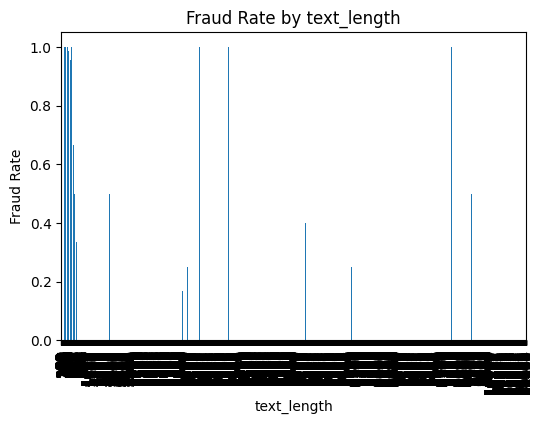

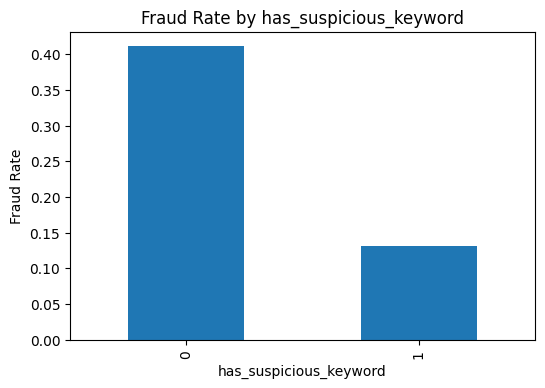

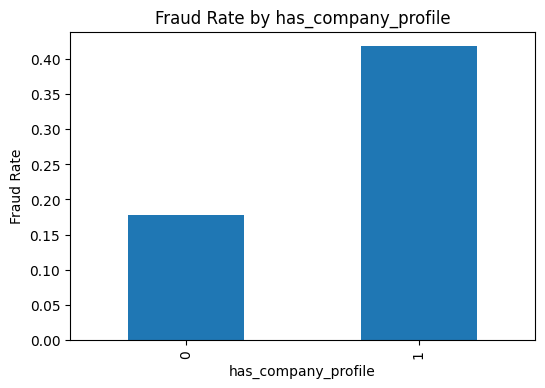

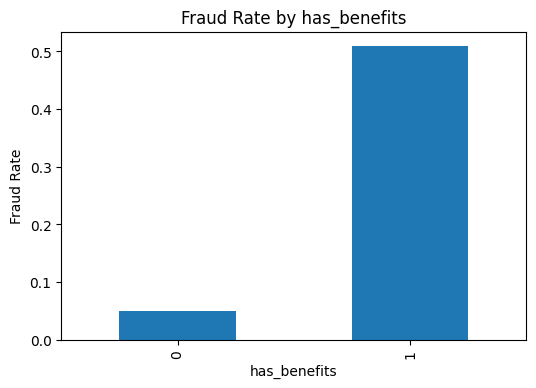

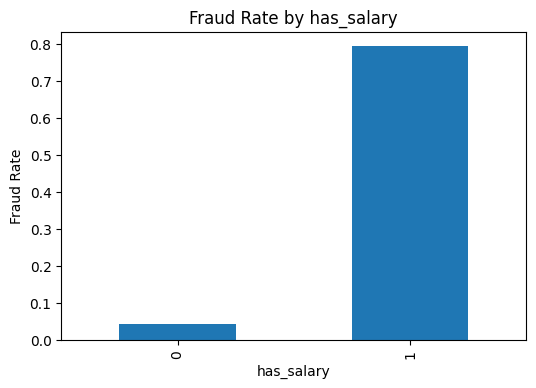


--- LOGIC 2: CLUSTERING ANALYSIS ---
Fraud Rate per Discovered Cluster:
             mean  count
cluster                 
0        1.000000   2081
2        1.000000   7919
3        0.081456   9232
1        0.014390   7922
4        0.000000    726

--- LOGIC 3: MULTIVARIATE CORRELATION HEATMAP ---


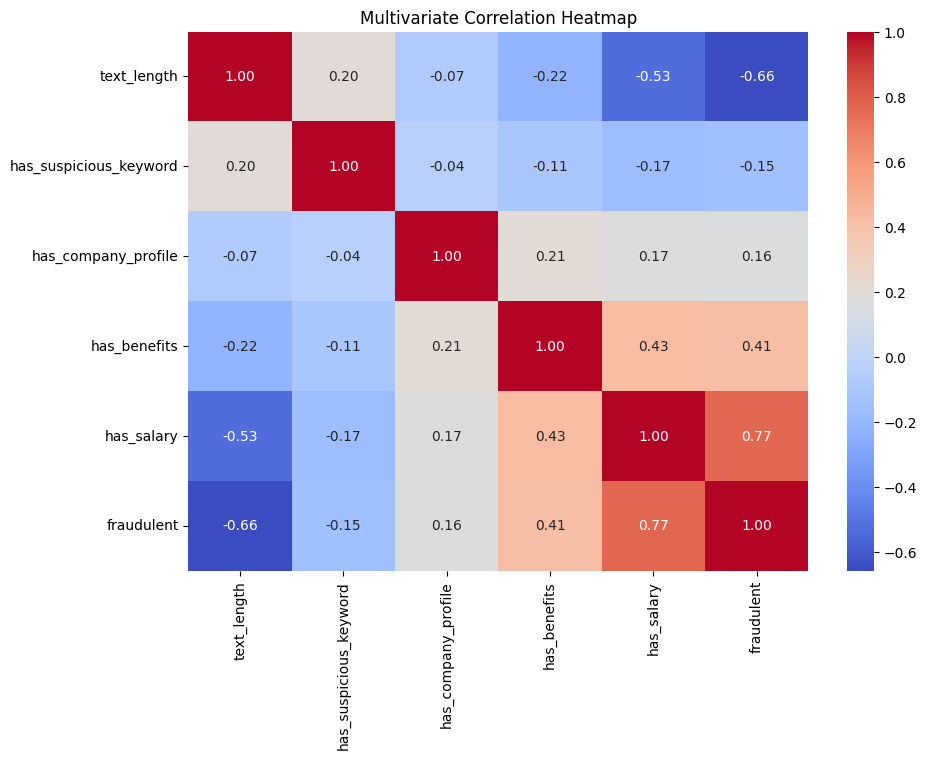

In [ ]:
# CELL 4: EXPLORATORY ANALYSIS

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# --- Logic 1: Bivariate Analysis ---
print("--- LOGIC 1: BIVARIATE ANALYSIS ---")
numerical_features = ['text_length', 'has_suspicious_keyword', 'has_company_profile', 'has_benefits', 'has_salary']
for feature in numerical_features:
    plt.figure(figsize=(6, 4))
    master_df.groupby(feature)['fraudulent'].mean().plot(kind='bar', title=f'Fraud Rate by {feature}')
    plt.ylabel('Fraud Rate')
    plt.show()

# --- Logic 2: Clustering Analysis ---
print("\n--- LOGIC 2: CLUSTERING ANALYSIS ---")
tfidf = TfidfVectorizer(stop_words='english', max_features=500)
text_vectors = tfidf.fit_transform(master_df['full_text'])
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
master_df['cluster'] = kmeans.fit_predict(text_vectors)
cluster_analysis = master_df.groupby('cluster')['fraudulent'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
print("Fraud Rate per Discovered Cluster:")
print(cluster_analysis)

# --- Logic 3: Multivariate Analysis ---
print("\n--- LOGIC 3: MULTIVARIATE CORRELATION HEATMAP ---")
plt.figure(figsize=(10, 7))
sns.heatmap(master_df[numerical_features + ['fraudulent']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Multivariate Correlation Heatmap')
plt.show()

In [ ]:
# CELL: CREATE SALARY BASELINE-----BIVARIATE ANALYSIS ONE

import numpy as np

# 1. Isolate non-fraudulent job posts that have salary information
safe_jobs_df = master_df[(master_df['fraudulent'] == 0) & (master_df['salaryRange'].notna())].copy()
print(f"Found {len(safe_jobs_df)} non-fraudulent posts with salary info to analyze.")

# 2. Define a function to convert salary ranges (e.g., "50000-70000") to a single average number
def get_avg_salary(salary_range):
    if isinstance(salary_range, str):
        try:
            # Clean up the string and split by the dash
            parts = [float(part.strip()) for part in salary_range.replace('$', '').replace(',', '').split('-')]
            # Calculate the average of the parts (handles single numbers and ranges)
            return sum(parts) / len(parts)
        except (ValueError, TypeError):
            # If conversion fails, return NaN (Not a Number)
            return np.nan
    return np.nan # Return NaN if the input is not a string

# 3. Apply this function to create a new 'avg_salary' column
safe_jobs_df['avg_salary'] = safe_jobs_df['salaryRange'].apply(get_avg_salary)

# 4. Drop any rows where we couldn't parse the salary or where experience is missing
safe_jobs_df.dropna(subset=['avg_salary', 'required_experience'], inplace=True)

# 5. Group by experience level and calculate the salary statistics
expected_salary_bands = safe_jobs_df.groupby('required_experience')['avg_salary'].agg(
    expected_mean_salary='mean',
    std_dev_salary='std',
    sample_count='count'
).sort_values(by='expected_mean_salary')

print("\n--- Expected Salary Bands (Based on your 'Safe' data) ---")
display(expected_salary_bands)

Found 2645 non-fraudulent posts with salary info to analyze.

--- Expected Salary Bands (Based on your 'Safe' data) ---


,expected_mean_salary,std_dev_salary,sample_count
required_experience,,,
Internship,1.784411e+04,3.194364e+04,70
Entry level,4.443686e+04,1.590033e+05,531
Not Applicable,4.606770e+04,6.453960e+04,254
Associate,7.482262e+04,3.844833e+05,528
Director,9.463698e+04,6.590179e+04,85
Executive,1.071139e+05,1.194369e+05,36
Mid-Senior level,2.180192e+06,4.203564e+07,804


In [ ]:
# CELL: TEST ALL SALARIES AGAINST THE BASELINE SLAB

# 1. First, we need to create the numerical 'avg_salary' column for the *entire* master_df
# We will reuse the same function from before.
print("🔄 Creating numerical 'avg_salary' column for the main DataFrame...")
master_df['avg_salary'] = master_df['salaryRange'].apply(get_avg_salary)
print("✅ 'avg_salary' column created.")

# 2. Define the function that checks if a salary is an outlier
def check_salary_outlier(row):
    """
    This function checks if a row's salary is suspiciously high.
    It returns 1 if suspicious, 0 otherwise.
    """
    experience = row['required_experience']
    salary = row['avg_salary']

    # We can only check if we have experience and salary data
    if pd.notna(experience) and pd.notna(salary):
        try:
            # Look up the expected salary band for this experience level
            band = expected_salary_bands.loc[experience]
            mean_salary = band['expected_mean_salary']
            std_dev = band['std_dev_salary']

            # If std_dev is NaN (happens if there's only one sample), we can't check
            if pd.isna(std_dev):
                return 0

            # Define our suspicion threshold (e.g., mean + 2 standard deviations)
            suspicion_threshold = mean_salary + (2 * std_dev)

            # Flag as an outlier if the salary is above the threshold
            if salary > suspicion_threshold:
                return 1 # Suspicious

        except KeyError:
            # This happens if the experience level was not in our 'safe jobs' baseline
            return 0 # Not enough data to say it's suspicious

    # Return 0 if not suspicious or if data is missing
    return 0

# 3. Apply this function to every row in the master_df to create the new feature
print("\n🔍 Testing every job post against the salary baseline...")
master_df['is_salary_outlier'] = master_df.apply(check_salary_outlier, axis=1)
print("✅ Salary outlier test complete!")

# 4. Analyze the results
print("\n--- Analysis of the new 'is_salary_outlier' feature ---")
# Use a crosstab to see how well our new feature correlates with actual fraud
outlier_fraud_crosstab = pd.crosstab(master_df['is_salary_outlier'], master_df['fraudulent'])
print(outlier_fraud_crosstab)

# Display some of the posts that were flagged
print("\n--- Examples of Posts Flagged with Suspicious Salaries ---")
display(master_df[master_df['is_salary_outlier'] == 1][[
    'title', 'required_experience', 'salaryRange', 'avg_salary', 'fraudulent'
]].head())

🔄 Creating numerical 'avg_salary' column for the main DataFrame...
✅ 'avg_salary' column created.

🔍 Testing every job post against the salary baseline...
✅ Salary outlier test complete!

--- Analysis of the new 'is_salary_outlier' feature ---
fraudulent             0      1
is_salary_outlier              
0                  16990  10849
1                     24     17

--- Examples of Posts Flagged with Suspicious Salaries ---


,title,required_experience,salaryRange,avg_salary,fraudulent
10741,Online Director,Not Applicable,100000-600000,3.500000e+05,0
11225,software trainee,Not Applicable,124000-375000,2.495000e+05,0
13146,National Sales Manager,Mid-Senior level,800000000-1200000000,1.000000e+09,0
14465,Project Manager,Not Applicable,0-1200000,6.000000e+05,0
14919,Ninja Tech Card,Entry level,350000-500000,4.250000e+05,0


--- Statistical Analysis for 'Safe' Jobs ---


,mean_salary,median_salary,std_dev_salary,job_post_count
telecommuting,,,,
0,852642.239427,45000.0,2.584857e+07,2128
1,146693.505556,40000.0,7.993681e+05,180



--- Visualization for 'Safe' Jobs ---


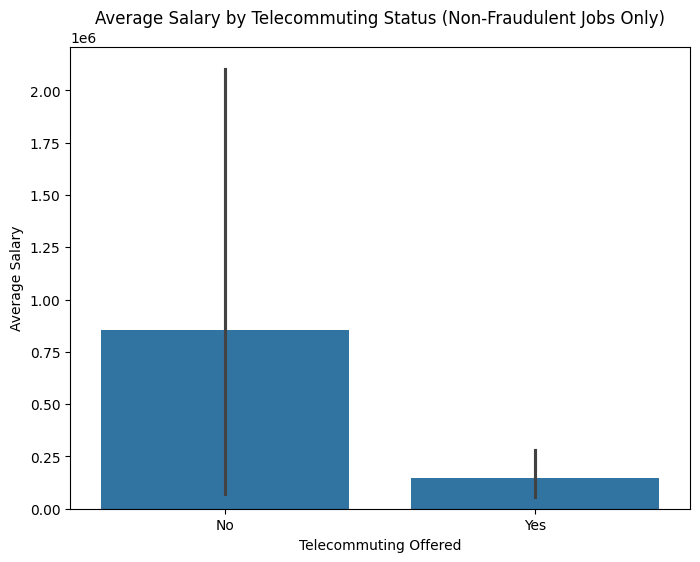

In [ ]:
# CELL: TELECOMMUTING VS. SALARY ANALYSIS ON SAFE DATASET

import seaborn as sns
import matplotlib.pyplot as plt

# 1. Ensure we are using the 'safe_jobs_df' (non-fraudulent posts)
# This DataFrame should already be created from previous steps.
# If not, you can create it with:
# safe_jobs_df = master_df[master_df['fraudulent'] == 0].copy()
# safe_jobs_df['avg_salary'] = safe_jobs_df['salaryRange'].apply(get_avg_salary)

# 2. Prepare the data by dropping rows where the relevant info is missing
analysis_df = safe_jobs_df.dropna(subset=['telecommuting', 'avg_salary']).copy()
analysis_df['telecommuting'] = analysis_df['telecommuting'].astype(int)

print("--- Statistical Analysis for 'Safe' Jobs ---")
# 3. Group by telecommuting status and calculate salary statistics
salary_by_telecommuting_safe = analysis_df.groupby('telecommuting')['avg_salary'].agg(
    mean_salary='mean',
    median_salary='median',
    std_dev_salary='std',
    job_post_count='count'
)
display(salary_by_telecommuting_safe)


print("\n--- Visualization for 'Safe' Jobs ---")
# 4. Create the bar plot for a clear visual comparison
plt.figure(figsize=(8, 6))
sns.barplot(
    data=analysis_df,
    x='telecommuting',
    y='avg_salary'
)
plt.title('Average Salary by Telecommuting Status (Non-Fraudulent Jobs Only)')
plt.ylabel('Average Salary')
plt.xlabel('Telecommuting Offered')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

In [ ]:
# CELL: TEST ALL SALARIES AGAINST THE TELECOMMUTING BASELINE



# --- 2. Define the function that checks if a salary is an outlier ---
def check_salary_outlier_telecommuting(row):
    telecommuting_status = row['telecommuting']
    salary = row['avg_salary']

    if pd.notna(telecommuting_status) and pd.notna(salary):
        try:
            band = salary_by_telecommuting_safe.loc[int(telecommuting_status)]
            mean_salary = band['mean_salary']
            std_dev = band['std_dev_salary']

            if pd.isna(std_dev): return 0

            suspicion_threshold = mean_salary + (2 * std_dev)
            if salary > suspicion_threshold:
                return 1 # Suspicious outlier
        except KeyError:
            return 0 # This status wasn't in our baseline
    return 0


# --- 3. Apply this function to the entire master_df ---
print("\n🔍 Testing every job post against the telecommuting salary baseline...")
master_df['is_salary_outlier_telecommuting'] = master_df.apply(check_salary_outlier_telecommuting, axis=1)
print("✅ Salary outlier test complete!")


# --- 4. Analyze the results ---
print("\n--- Analysis of the new 'is_salary_outlier_telecommuting' feature ---")
# Use a crosstab to see how well our new rule correlates with actual fraud
outlier_fraud_crosstab = pd.crosstab(master_df['is_salary_outlier_telecommuting'], master_df['fraudulent'])
print(outlier_fraud_crosstab)


🔍 Testing every job post against the telecommuting salary baseline...
✅ Salary outlier test complete!

--- Analysis of the new 'is_salary_outlier_telecommuting' feature ---
fraudulent                           0      1
is_salary_outlier_telecommuting              
0                                17010  10866
1                                    4      0


✅ Decision Tree model trained successfully!

--- Decision Tree Rules ---


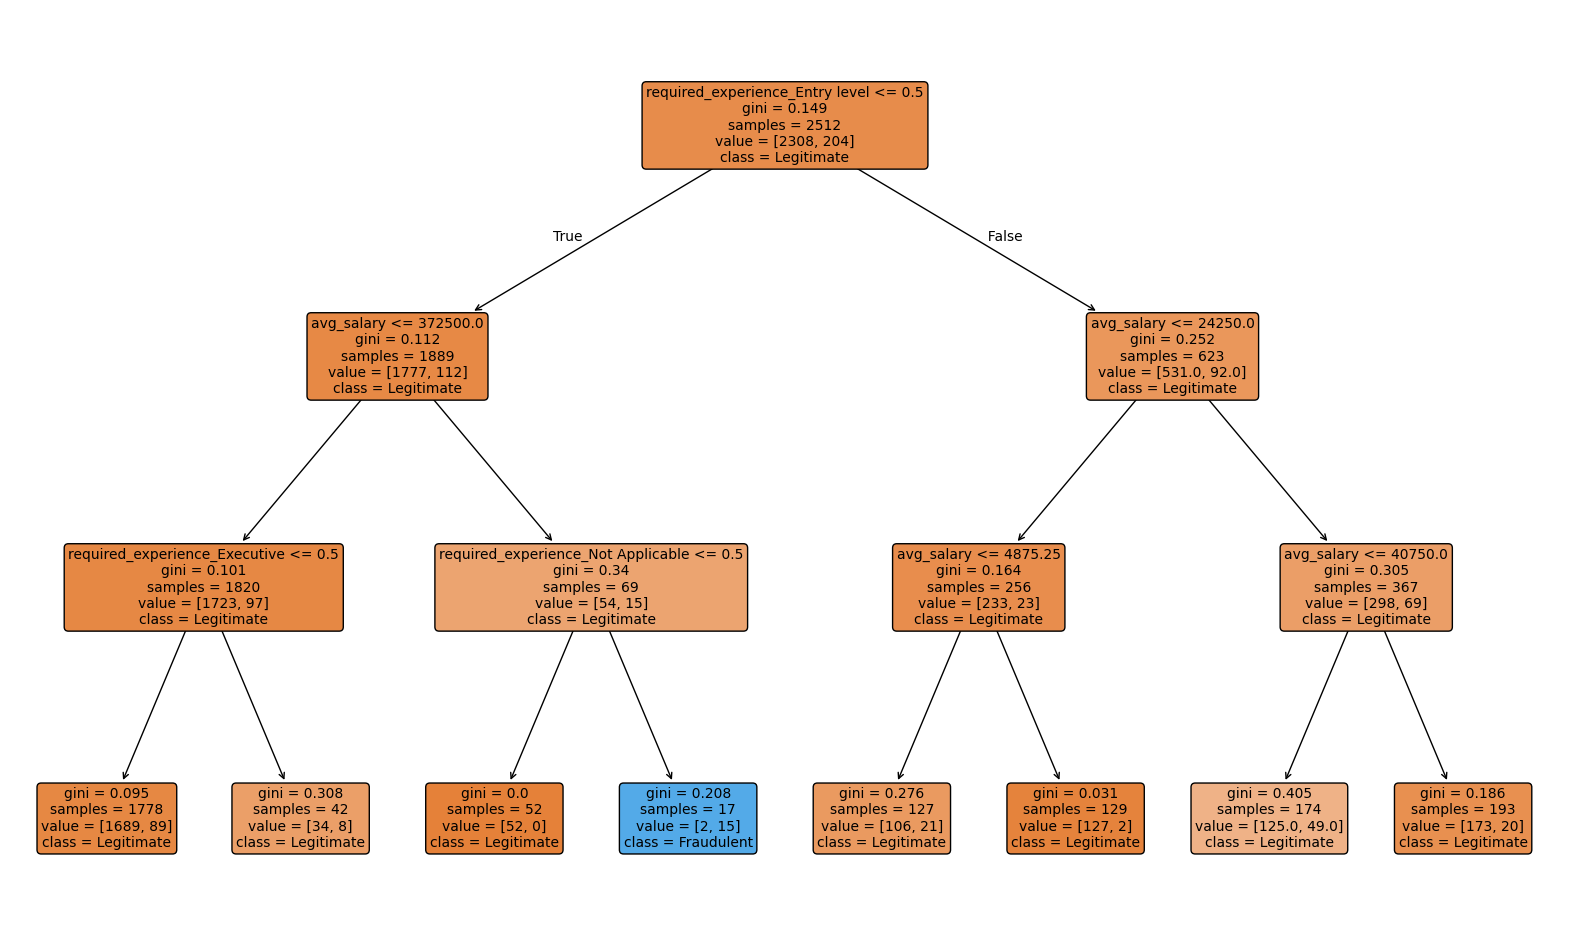

In [ ]:
# CELL: MULTIVARIATE ANALYSIS WITH A DECISION TREE

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Prepare the Data ---
# Select the features we want to analyze
features = ['required_experience', 'telecommuting', 'avg_salary', 'fraudulent']
analysis_df = master_df[features].dropna().copy()

# Decision trees need all input to be numerical. We'll convert 'required_experience'
# into separate 0/1 columns using one-hot encoding.
X = pd.get_dummies(analysis_df.drop('fraudulent', axis=1), columns=['required_experience'])
y = analysis_df['fraudulent']

# Get feature names for the plot
feature_names = X.columns.tolist()

# --- 2. Train the Decision Tree Model ---
# We'll use a shallow tree (max_depth=3) so it's easy to read and interpret
dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_model.fit(X, y)
print("✅ Decision Tree model trained successfully!")

# --- 3. Visualize the Tree ---
print("\n--- Decision Tree Rules ---")
plt.figure(figsize=(20, 12))
plot_tree(
    dt_model,
    feature_names=feature_names,
    class_names=['Legitimate', 'Fraudulent'], # 0 = Legitimate, 1 = Fraudulent
    filled=True,
    rounded=True,
    fontsize=10
)
plt.show()

In [ ]:
# CELL: GENERATE PREDICTIONS (OUTLIER COLUMN) FROM DECISION TREE

from sklearn.metrics import confusion_matrix, classification_report

# 1. Use the trained decision tree (dt_model) to make a prediction for every row
# The 'X' DataFrame is the one-hot encoded data we created in the last step
predictions = dt_model.predict(X)

# 2. Create the new column in your analysis_df to store the predictions
# This is your new "suspicious outlier" column
analysis_df['dt_prediction'] = predictions

print("✅ New 'dt_prediction' column created!")

# 3. Analyze how well the model's predictions match the actual 'fraudulent' labels
print("\n--- Model Performance Analysis ---")

# A confusion matrix shows True/False Positives and Negatives
print("Confusion Matrix:")
print(confusion_matrix(y, predictions))

# A classification report gives you precision, recall, and f1-score
print("\nClassification Report:")
print(classification_report(y, predictions, target_names=['Legitimate', 'Fraudulent']))

# 4. Display a few examples of the predictions vs. the actual labels
print("\n--- Examples of Predictions vs. Actual Labels ---")
display(analysis_df[['fraudulent', 'dt_prediction', 'required_experience', 'avg_salary', 'telecommuting']].head(10))

✅ New 'dt_prediction' column created!

--- Model Performance Analysis ---
Confusion Matrix:
[[2306    2]
 [ 189   15]]

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.92      1.00      0.96      2308
  Fraudulent       0.88      0.07      0.14       204

    accuracy                           0.92      2512
   macro avg       0.90      0.54      0.55      2512
weighted avg       0.92      0.92      0.89      2512


--- Examples of Predictions vs. Actual Labels ---


,fraudulent,dt_prediction,required_experience,avg_salary,telecommuting
10013,0,0,Mid-Senior level,24000.0,0.0
10017,0,0,Mid-Senior level,110000.0,0.0
10022,0,0,Executive,135000.0,0.0
10030,0,0,Executive,110000.0,0.0
10038,0,0,Associate,57500.0,0.0
10049,0,0,Entry level,45000.0,0.0
10083,0,0,Associate,67500.0,0.0
10084,0,0,Mid-Senior level,95.0,0.0
10099,0,0,Entry level,22000.0,1.0
10105,1,0,Mid-Senior level,105000.0,0.0


--- Starting clustering for the final master dataset ---
✅ Successfully loaded data from master_dataset_cleaned.csv

📦 Cluster Summary:
Number of data points in each cluster:
cluster
0     7223
1     9399
2    11258
Name: count, dtype: int64

🔍 Mean feature values for each cluster:


,telecommuting,has_company_profile,has_benefits,has_salary,has_suspicious_keyword,length_title,length_description,length_requirements
cluster,,,,,,,,
0,0.029628,0.766994,0.000000,0.100374,0.126817,27.891735,1322.500346,545.627717
1,0.053836,0.847324,1.000000,0.095968,0.115331,29.595808,1212.691244,655.554314
2,0.004175,0.983123,0.998223,0.998490,0.010926,21.271629,198.101794,103.500266


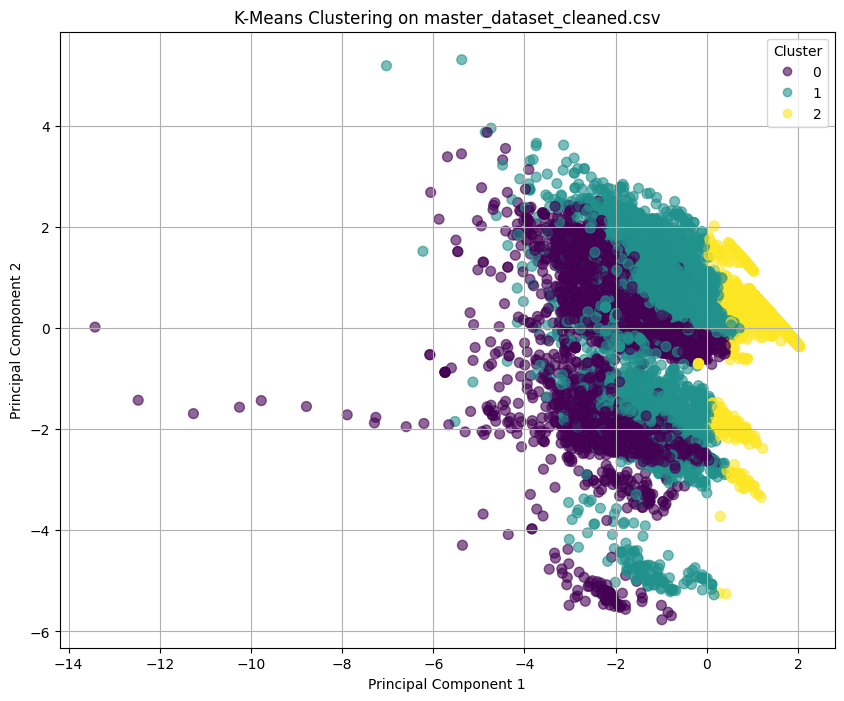

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def perform_clustering(file_path):
    """
    Performs K-Means clustering on the specified dataset.

    Args:
        file_path (str): The path to the CSV file.
    """
    try:
        # --- FIX 1: Use the file_path argument to load the correct file ---
        df = pd.read_csv(file_path)
        print(f"✅ Successfully loaded data from {file_path.split('/')[-1]}")
    except FileNotFoundError:
        print(f"❌ Error: The file '{file_path}' was not found. Please check the path.")
        return

    # Step 1: Select features and preprocess the data
    # --- FIX 2: Updated the features to match your master_df ---
    features = [
        'telecommuting', 'has_company_profile', 'has_benefits', 'has_salary',
        'has_suspicious_keyword', 'is_salary_outlier', 'is_salary_outlier_telecommuting'
    ]
    text_features = ['title', 'description', 'requirements']

    # Ensure all selected features actually exist in the dataframe
    features = [f for f in features if f in df.columns]

    # Impute missing values for numerical features
    imputer = SimpleImputer(strategy='median')
    df[features] = imputer.fit_transform(df[features])

    # Create new features based on the length of text columns
    for col in text_features:
        if col in df.columns:
            df[f'length_{col}'] = df[col].fillna('').apply(len)
            features.append(f'length_{col}')

    # Drop any rows with remaining NaN values
    df.dropna(subset=features, inplace=True)

    # Step 2: Scale the data
    scaler = StandardScaler()
    X = df[features]
    X_scaled = scaler.fit_transform(X)

    # Step 3: Perform K-Means clustering (k=3)
    kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
    df['cluster'] = kmeans.fit_predict(X_scaled)

    # Step 4: Analyze and interpret the clusters
    print("\n📦 Cluster Summary:")
    print(f"Number of data points in each cluster:\n{df['cluster'].value_counts().sort_index()}")

    print("\n🔍 Mean feature values for each cluster:")
    cluster_summary = df.groupby('cluster')[features].mean()
    display(cluster_summary)

    # Step 5: Visualize the clusters using PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X_scaled)
    df['PCA1'] = principal_components[:, 0]
    df['PCA2'] = principal_components[:, 1]

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(df['PCA1'], df['PCA2'], c=df['cluster'], cmap='viridis', s=50, alpha=0.6)
    plt.title(f'K-Means Clustering on {file_path.split("/")[-1]}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(*scatter.legend_elements(), title='Cluster')
    plt.grid(True)
    plt.show()

# --- Run the clustering for your final, cleaned master file ---
final_file_path = '/content/drive/MyDrive/Colab Notebooks/master_dataset_cleaned.csv'
print("--- Starting clustering for the final master dataset ---")
perform_clustering(final_file_path)

In [ ]:
# CELL 5: PREPARE DATA FOR DISTILBERT

from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast
import torch

# 1. Split data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    master_df['full_text'].tolist(), master_df['fraudulent'].tolist(), test_size=0.2, random_state=42
)

# 2. Load the tokenizer and encode the text
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

# 3. Create the PyTorch Dataset class
class JobPostDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

# 4. Create the dataset objects
train_dataset = JobPostDataset(train_encodings, train_labels)
val_dataset = JobPostDataset(val_encodings, val_labels)

print("✅ Data is prepped and ready for DistilBERT training!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

✅ Data is prepped and ready for DistilBERT training!


In [ ]:
# CELL: CONFIGURE & TRAIN DISTILBERT (CORRECTED)

import os
os.environ["WANDB_DISABLED"] = "true"

from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

# 1. Load the pre-trained model
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2 # 2 labels: Not Fraudulent (0) and Fraudulent (1)
)

# 2. Define training arguments
training_args = TrainingArguments(
    output_dir='/content/drive/My Drive/AI-CyberShield/results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    logging_dir='./logs',
    # THE FIX: Changed 'evaluation_strategy' to 'eval_strategy'
    eval_strategy="epoch",
)

# 3. Create and run the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

print("\n🔥 Starting final model training! This may take several minutes...")
trainer.train()
print("🎉 Training finished!")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



🔥 Starting final model training! This may take several minutes...


Epoch,Training Loss,Validation Loss
1,0.073800,0.054713
2,0.029800,0.064705
3,0.011700,0.061746


🎉 Training finished!


In [ ]:
# CELL 7: SAVE FINAL MODEL TO DRIVE

# 1. Define the final save path in your Google Drive
final_model_path = '//content/drive/MyDrive/Colab Notebooks/hack_model'

# 2. Save the model and tokenizer
print(f"💾 Saving the fine-tuned model to: {final_model_path}")
trainer.save_model(final_model_path)
tokenizer.save_pretrained(final_model_path)

print("✅ Model saved successfully to your Google Drive!")

💾 Saving the fine-tuned model to: //content/drive/MyDrive/Colab Notebooks/hack_model
✅ Model saved successfully to your Google Drive!


In [ ]:
# CELL: LOAD SAVED FINE-TUNED MODEL

from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast
import torch
import torch.nn.functional as F

# 1. Define the path to your saved model in Google Drive
model_path = '/content/drive/MyDrive/Colab Notebooks/hack_model'

# 2. Load the tokenizer and the model from the specified path
try:
    tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
    model = DistilBertForSequenceClassification.from_pretrained(model_path)
    # Set the model to evaluation mode (important for inference)
    model.eval()
    print(f"✅ Model and tokenizer loaded successfully from {model_path}")

except OSError:
    print(f"❌ ERROR: Could not find a saved model at the path: {model_path}")
    print("Please make sure the path is correct and the folder contains the model files.")


# --- Example: How to use the loaded model for a prediction ---
if 'model' in locals():
    sample_text = "We are urgently hiring a data entry clerk for a remote position. No experience needed, high pay. Apply now!"

    # Tokenize the text
    inputs = tokenizer(sample_text, return_tensors="pt", truncation=True, padding=True)

    # Make a prediction (no gradient calculation needed)
    with torch.no_grad():
        logits = model(**inputs).logits

    # Get the probability and the predicted class ID
    probabilities = F.softmax(logits, dim=1).squeeze()
    predicted_class_id = torch.argmax(probabilities).item()

    # Assuming 0 = Legitimate, 1 = Fraudulent
    prediction = "Fraudulent" if predicted_class_id == 1 else "Legitimate"
    confidence = probabilities[predicted_class_id].item()

    print("\n--- Prediction Example ---")
    print(f"Sample Text: '{sample_text}'")
    print(f"Prediction: {prediction}")
    print(f"Confidence: {confidence:.2%}")

✅ Model and tokenizer loaded successfully from /content/drive/MyDrive/Colab Notebooks/hack_model

--- Prediction Example ---
Sample Text: 'We are urgently hiring a data entry clerk for a remote position. No experience needed, high pay. Apply now!'
Prediction: Fraudulent
Confidence: 99.98%


⚡ Running a quick evaluation on a sample of 500 data points...
🔍 Making predictions on the validation sample...


  0%|          | 0/16 [00:00<?, ?it/s]

✅ Predictions complete!

--- Model Performance Metrics (on Sample Data) ---
                precision    recall  f1-score   support

Legitimate (0)       0.98      1.00      0.99       324
Fraudulent (1)       0.99      0.97      0.98       176

      accuracy                           0.99       500
     macro avg       0.99      0.98      0.98       500
  weighted avg       0.99      0.99      0.99       500


--- Confusion Matrix (on Sample Data) ---


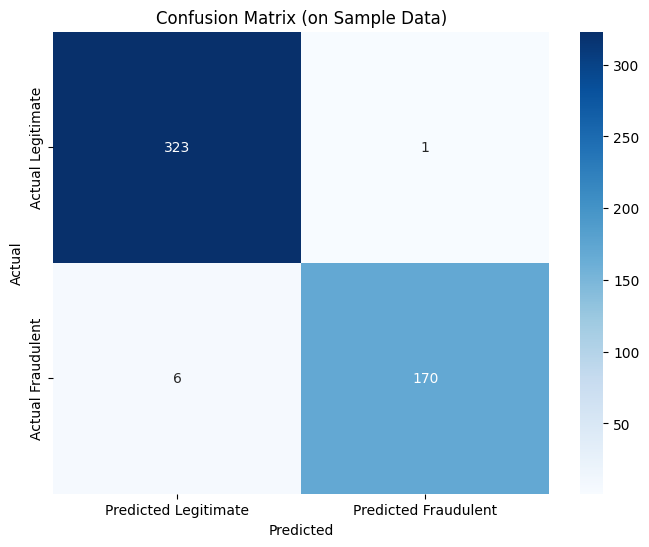

In [ ]:
# CELL: QUICK MODEL EVALUATION (WITH PLOTTING FIX)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

# --- Define the sample size ---
sample_size = 500
sample_val_texts = val_texts[:sample_size]
sample_val_labels = val_labels[:sample_size]
print(f"⚡ Running a quick evaluation on a sample of {sample_size} data points...")


# --- 1. Make Predictions on the smaller Validation Set ---
print("🔍 Making predictions on the validation sample...")
batch_size = 32
predictions = []
true_labels = []
for i in tqdm(range(0, len(sample_val_texts), batch_size)):
    batch_texts = sample_val_texts[i:i+batch_size]
    batch_labels = sample_val_labels[i:i+batch_size]
    inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class_ids = torch.argmax(logits, dim=1)
    predictions.extend(predicted_class_ids.cpu().numpy())
    true_labels.extend(batch_labels)
print("✅ Predictions complete!")


# --- 2. Calculate and Print Metrics ---
print("\n--- Model Performance Metrics (on Sample Data) ---")
report = classification_report(true_labels, predictions, target_names=['Legitimate (0)', 'Fraudulent (1)'])
print(report)


# --- 3. Visualize the Confusion Matrix ---
print("\n--- Confusion Matrix (on Sample Data) ---")
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Legitimate', 'Predicted Fraudulent'],
            # THE FIX: Changed 'ytickslabel' to 'yticklabels'
            yticklabels=['Actual Legitimate', 'Actual Fraudulent'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (on Sample Data)')
plt.show()

In [ ]:
# CELL: IMAGE-TO-TEXT (OCR) WITH INTERACTIVE UPLOAD

# 1. Install the EasyOCR library
print("🚀 Installing EasyOCR library...")
!pip install easyocr -q
print("✅ Installation complete!")

import easyocr
import os
from google.colab import files
import io

# 2. Initialize the OCR reader for English
try:
    reader = easyocr.Reader(['en'])
    print("✅ EasyOCR reader initialized.")
except Exception as e:
    print(f"❌ Error initializing reader: {e}")


# 3. Define the function to extract text from an image
def extract_text_from_image(image_path):
    """
    Takes the path to an image file and returns the extracted text as a single string.
    """
    if not os.path.exists(image_path):
        return "Error: Image file not found at the specified path."

    result = reader.readtext(image_path)
    full_text = ' '.join([text for bbox, text, prob in result])
    return full_text


# --- 4. Interactive Upload and Test ---
print("\n--- Please upload a sample image of a job post ---")
uploaded = files.upload()

# Check if a file was uploaded
if len(uploaded.keys()) > 0:
    # Get the name and content of the uploaded file
    filename = list(uploaded.keys())[0]
    content = uploaded[filename]

    # Save the uploaded file to the Colab environment
    with open(filename, 'wb') as f:
        f.write(content)

    print(f"\n✅ File '{filename}' uploaded successfully.")

    # Run the OCR function on the uploaded image
    print("\n--- Extracting text from your uploaded image ---")
    extracted_text = extract_text_from_image(filename)

    print("\n--- Extracted Text ---")
    print(extracted_text)
else:
    # --- FIX: Added closing quote and parenthesis ---
    print("\nNo file was uploaded.")

🚀 Installing EasyOCR library...
✅ Installation complete!
✅ EasyOCR reader initialized.

--- Please upload a sample image of a job post ---


Saving OIP (1).webp to OIP (1).webp

✅ File 'OIP (1).webp' uploaded successfully.

--- Extracting text from your uploaded image ---

--- Extracted Text ---
Iild Splendour of the various-vested Nightl Mother of wildly-working visionsl haili watch thy gliding, while with watery light Thy  weak eye glimmers through vedl= nd when thou lovest orb to shroud Behind the d blackness lost on high; nd when thou dartest from the wind-rent cloud Thy placid lightning 0er the awakend sky: feecy thy pale gather' €


In [ ]:
# CELL: PREDICT ON A SAMPLE JOB POSTING

import torch
import torch.nn.functional as F

# --- ACTION: Paste the job description you want to test below ---
sample_job_post = """
Job Title: Data Analyst – Retail Analytics
Company: Horizon Retail Group
Location: Bengaluru, India (Hybrid)
Employment Type: Full-Time

About the Role:
Horizon Retail Group is seeking a Data Analyst to support our merchandising and customer insights team. The ideal candidate will analyze sales data to improve inventory planning and pricing strategies.

Responsibilities:

Collect, clean, and analyze large datasets using SQL and Python.

Prepare dashboards and reports for senior management.

Collaborate with marketing to identify customer trends and growth opportunities.

Qualifications:

Bachelor’s degree in Statistics, Economics, Computer Science, or related field.

1–3 years of experience in data analysis or business intelligence.

Proficiency in SQL, Excel, and visualization tools (Tableau/Power BI).

Compensation & Benefits:

Competitive salary with performance bonus.

Health insurance, paid time off, and retirement benefits.

Professional development opportunities and annual training budget.
"""

# --- Prediction Logic ---

# Check if the model and tokenizer are loaded
if 'model' in locals() and 'tokenizer' in locals():
    # Tokenize the sample text
    inputs = tokenizer(sample_job_post, return_tensors="pt", truncation=True, padding=True)

    # Make a prediction
    with torch.no_grad():
        logits = model(**inputs).logits

    # Get the probabilities and the final prediction
    probabilities = F.softmax(logits, dim=1).squeeze()
    predicted_class_id = torch.argmax(probabilities).item()
    confidence = probabilities[predicted_class_id].item()

    prediction = "Fraudulent" if predicted_class_id == 1 else "Legitimate"

    # Display the result
    print("\n--- Model Prediction ---")
    if prediction == "Fraudulent":
        print(f"🚩 Prediction: {prediction}")
    else:
        print(f"✅ Prediction: {prediction}")

    print(f"Confidence: {confidence:.2%}")

else:
    print("❌ Error: Model not found. Please run the 'Load Model' cell first.")


--- Model Prediction ---
✅ Prediction: Legitimate
Confidence: 99.90%
